# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

**Columns explanation**


About
The data provided by STEG is composed of two files. The first one is comprised of client data and the second one contains billing history from 2005 to 2019.

There are 2 .zip files for download, train.zip, and test.zip and a SampleSubmission.csv. In each .zip file you will find a client and invoice file.

Variable definitions

Client:

* Client_id: Unique id for client
* District: District where the client is
* Client_catg: Category client belongs to
* Region: Area where the client is
* Creation_date: Date client joined
* Target: fraud:1 , not fraud: 0

Invoice data

* Client_id: Unique id for the client
* Invoice_date: Date of the invoice
* Tarif_type: Type of tax
* Counter_number:
* Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
* Counter_code:
* Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
* Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
* Consommation_level_1: Consumption_level_1
* Consommation_level_2: Consumption_level_2
* Consommation_level_3: Consumption_level_3
* Consommation_level_4: Consumption_level_4
* Old_index: Old index
* New_index: New index
* Months_number: Month number
* Counter_type: Type of counter

In [16]:
# Import libraries

In [48]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from src.preprocessing.agg_invoice import agg_invoice_num_mode_no_monthly_weighting, agg_invoice_num_mode_monthly_weighting
from src.preprocessing.cleaning import convert_dtype_cat_date



from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')

#from sqalchemy import create_engine
#from dotenv import load_dotenv

ImportError: cannot import name 'agg_invoice_num_mode_monthly_weighting' from 'src.preprocessing.agg_invoice' (/Users/neuefische/repos/ml_project_mariusbosch/gas-fraud-team-crime/src/preprocessing/agg_invoice.py)

In [18]:
df_client_train = pd.read_csv('data/train/client_train.csv')
df_invoice_train = pd.read_csv('data/train/invoice_train.csv')

In [19]:
# Convert date time format

df_invoice_train['invoice_date'] = pd.to_datetime(df_invoice_train['invoice_date'])
df_client_train['creation_date'] = pd.to_datetime(df_client_train['creation_date'])


In [20]:
# Feature engineering (aggregate)

df_invoice= agg_invoice_num_mode_monthly_weighting(df_invoice_train)

In [21]:
# merge dataframes

df_combined = pd.merge(df_client_train, df_invoice, on='client_id', how='inner')


In [22]:
# call cleaning function (convert categories, rename columns, etc.)

df_combined = convert_dtype_cat_date(df_combined) 

In [23]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   district              135493 non-null  category      
 1   client_id             135493 non-null  object        
 2   client_catg           135493 non-null  category      
 3   region                135493 non-null  category      
 4   creation_date         135493 non-null  datetime64[ns]
 5   target                135493 non-null  float64       
 6   consommation_level_1  135493 non-null  float64       
 7   consommation_level_2  135493 non-null  float64       
 8   consommation_level_3  135493 non-null  float64       
 9   consommation_level_4  135493 non-null  float64       
 10  counter_coefficient   135493 non-null  float64       
 11  months_number         135493 non-null  float64       
 12  invoice_date          135493 non-null  datetime64[ns]
 13 

In [24]:
# Feature engineering (one hot encode all categorical variables)

categorical_variables = ['district','client_catg','region', 'tarif_type','counter_statue','counter_code','reading_remarque','counter_type'] # all categorical variables
df_combined_encoded = [[]]
df_combined_encoded = pd.get_dummies(df_combined, columns=categorical_variables, drop_first=True) # one hot encode all categorical variables

#df_combined_encoded.info()

In [25]:
# reconvert datetime to numeric

reconvert_to_numeric = ['creation_date','invoice_date']

for col in reconvert_to_numeric:
    df_combined_encoded[col] = pd.to_numeric(df_combined_encoded[col]) # convert datetime back into numeric

df_combined_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Columns: 108 entries, client_id to counter_type_GAZ
dtypes: bool(98), float64(7), int64(2), object(1)
memory usage: 23.0+ MB


In [26]:
# Define target(y) and features (X)

X = df_combined_encoded.drop(['target'], axis=1)
y = df_combined_encoded['target']

In [27]:
# We use Client_id as index from now on

X.set_index('client_id', inplace=True)

In [43]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [44]:
# decision tree test

dec_tree = DecisionTreeClassifier( 
            criterion = "gini",
            max_depth = 10, min_samples_leaf = 5)
dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test) 

y_pred_proba = dec_tree.predict_proba(X_test) 



---------------------------------------------------------------------------
Confusion Matrix: 
 [[25493    93]
 [ 1491    22]]
---------------------------------------------------------------------------
Accuracy : 
 94.15476585851876
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     25586
         1.0       0.19      0.01      0.03      1513

    accuracy                           0.94     27099
   macro avg       0.57      0.51      0.50     27099
weighted avg       0.90      0.94      0.92     27099



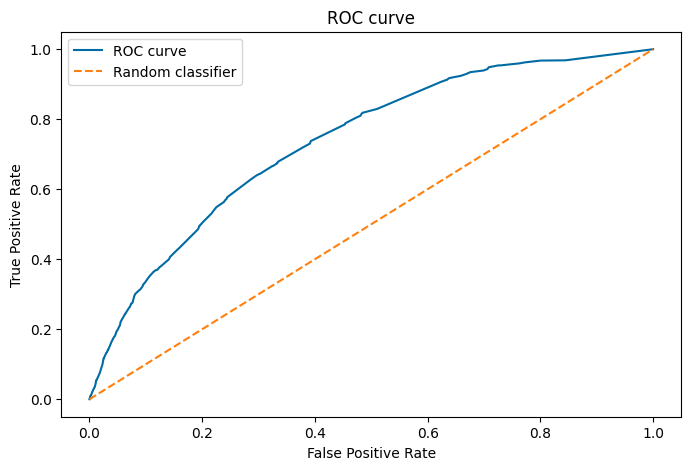

In [46]:
# evaluate test tree

print("-----"*15)
print("Confusion Matrix: \n", 
confusion_matrix(y_test, y_pred)) 

print("-----"*15)
print ("Accuracy : \n", 
accuracy_score(y_test, y_pred) * 100) 

print("-----"*15)
print("Report : \n", 
classification_report(y_test, y_pred))

roc_auc_score(y_test, y_pred_proba[:,1])

# plot roc curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [30]:
# SMOTE (after split & only for training dataset to prevent data leakage)

smote = SMOTE(sampling_strategy='auto') # we initialize smote, 'auto' --> resample all classes but the majority class, we can put a float here to 

'''When float, it corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling. Therefore, the ratio is expressed as 
 where 
 is the number of samples in the minority class after resampling and 
 is the number of samples in the majority class.'''

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

'''
Returns:
        X_resampled : {array-like, dataframe, sparse matrix} of shape \
                (n_samples_new, n_features)
            The array containing the resampled data.

        y_resampled : array-like of shape (n_samples_new,)
            The corresponding label of `X_resampled`.'''


'\nReturns:\n        X_resampled : {array-like, dataframe, sparse matrix} of shape                 (n_samples_new, n_features)\n            The array containing the resampled data.\n\n        y_resampled : array-like of shape (n_samples_new,)\n            The corresponding label of `X_resampled`.'

In [31]:
display(X_train.info(),X_train_resampled.info())

<class 'pandas.core.frame.DataFrame'>
Index: 108394 entries, train_Client_46032 to train_Client_74942
Columns: 106 entries, creation_date to counter_type_GAZ
dtypes: bool(98), float64(6), int64(2)
memory usage: 17.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204682 entries, 0 to 204681
Columns: 106 entries, creation_date to counter_type_GAZ
dtypes: bool(98), float64(6), int64(2)
memory usage: 31.6 MB


None

None

In [66]:
'''# Correlation before and after resampling

# correlation of target with features BEFORE resampling

df_corr_unsampled = df_combined_encoded
df_corr_unsampled.corr()['target'].sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.heatmap(df_corr_unsampled.corr().round(2), annot=True, cmap='coolwarm')
plt.show()

# correlation of target with features after resampling

df_corr_sampled = df_combined_encoded
df_corr_sampled.corr()['target'].sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.heatmap(df_corr_sampled.corr().round(2), annot=True, cmap='coolwarm')
plt.show()'''

KeyError: 'target'

In [ ]:
# test decision tree 

In [ ]:
# Scaling

In [ ]:
# Re-reconvert to datetime

In [ ]:
# safe X_train_resampled to import in other notebooks